# PokerML

In [10]:
# Disable some console warnings
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [11]:
import numpy as np

from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.utils import to_categorical

Make sure that you have Vivado suite in your environment.

In [12]:
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

## Configuration

In [13]:
DATA_DIR = "data"

MODELS_DIR = 'models/'
DATA_NPY_DIR = DATA_DIR + '/npy/'

IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
TEST_SIZE = 0.2
NUM_CLASSES = 52

QKERAS_TRAIN = True ## I did not debug yet the issue with the QKeras saved model

## Load data

In [14]:
X_train_val = np.load(DATA_NPY_DIR + 'X_train_val.npy')
X_test = np.load(DATA_NPY_DIR + 'X_test.npy')
y_train_val = np.load(DATA_NPY_DIR + 'y_train_val.npy')
y_test = np.load(DATA_NPY_DIR + 'y_test.npy')
classes = np.load(DATA_NPY_DIR + 'classes.npy', allow_pickle=True)

In [15]:
print('Train and validation set:', X_train_val.shape[0])
print('Test set:                ', X_test.shape[0])
print('Classes:                 ', classes.shape[0])

Train and validation set: 11980
Test set:                 2996
Classes:                  52


## Train QKeras model

In [16]:
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Activation
from qkeras import QDense, QActivation, QConv2D
from qkeras.quantizers import quantized_bits, quantized_relu

# # ENABLE THIS IF YOU USE PRUNING
# from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
# from tensorflow_model_optimization.sparsity.keras import strip_pruning
# import tensorflow_model_optimization as tfmot

import pickle

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

In [19]:
from qkeras import QActivation
from qkeras import QDense, QConv2DBatchnorm
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization


# Define the filters and neurons per layer
filters_per_conv_layer = [4, 8]
neurons_per_dense_layer = [32, NUM_CLASSES]

# Define input shape
x_in = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

# Initialize input tensor
x = x_in

# Add convolutional layers
for i, f in enumerate(filters_per_conv_layer):
    print(('Adding QConv2D block {} with N={} filters').format(i, f))
    x = QConv2D(
        f,
        kernel_size=(3, 3),
        kernel_quantizer="quantized_bits(6,0,alpha=1)",
        bias_quantizer="quantized_bits(6,0,alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        name='conv_%i' % i,
    )(x)
    x = QActivation('quantized_relu(6)', name='conv_act_%i' % i)(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool_%i' % i)(x)

# Flatten the output
x = Flatten()(x)

# Add dense layers
for i, n in enumerate(neurons_per_dense_layer):
    print(('Adding QDense block {} with N={} neurons').format(i, n))
    x = QDense(
        n,
        kernel_quantizer="quantized_bits(6,0,alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        name='dense_%i' % i,
        use_bias=False,
    )(x)
    x = BatchNormalization(name='bn_dense_%i' % i)(x)
    x = QActivation('quantized_relu(6)', name='dense_act_%i' % i)(x)

# Define output layer
x_out = QDense(
    NUM_CLASSES,
    kernel_quantizer="quantized_bits(6,0,alpha=1)",
    kernel_initializer='lecun_uniform',
    kernel_regularizer=l1(0.0001),
    activation='softmax',
    name='output',
)(x)

# Create the model
model = Model(inputs=[x_in], outputs=[x_out], name='qkeras')

# Print model summary
model.summary()

Adding QConv2D block 0 with N=4 filters
Adding QConv2D block 1 with N=8 filters
Adding QDense block 0 with N=32 neurons
Adding QDense block 1 with N=52 neurons
Model: "qkeras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv_0 (QConv2D)            (None, 62, 62, 4)         112       
                                                                 
 conv_act_0 (QActivation)    (None, 62, 62, 4)         0         
                                                                 
 pool_0 (MaxPooling2D)       (None, 31, 31, 4)         0         
                                                                 
 conv_1 (QConv2D)            (None, 29, 29, 8)         296       
                                                                 
 conv_act_1 (QActivation)    (No

In [20]:
if QKERAS_TRAIN:
    from qkeras.utils import model_save_quantized_weights

    # Using learning rate with exponential decay
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        0.001,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True
    )
    adam = Adam(learning_rate=lr_schedule)
    
    #adam = Adam(learning_rate=0.001)

    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])

    # A few other callbacks. These should not give warnings on deprecated features.
    callbacks = [
            ModelCheckpoint(
                CHECKPOINT_FILENAME,
                monitor='val_loss',
                verbose=0,
                save_best_only=True,
                save_weights_only=False,
                save_freq='epoch')
       #,
       #pruning_callbacks.UpdatePruningStep()
       #,#ReduceLROnPlateau(patience=75, min_delta=1**-6), 
    ]

    history = model.fit(
        X_train_val,
        y_train_val,
        batch_size=128,
        epochs=20,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks
    )
    
# # Strip the model of pruning information
#     model = strip_pruning(model)
#    model.save(CHECKPOINT_FILENAME)

    # Use this instead if you use the callbacks
    history_file = CHECKPOINT_FILENAME.replace('.h5', '-history.pkl')
    with open(history_file, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

    print(f'Saving history to: {history_file}')
    print(f'Saved checkpoint to: {CHECKPOINT_FILENAME}')


else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model(CHECKPOINT_FILENAME, custom_objects=co, compile=False)

Epoch 1/20
71/71 [==============================] - 11s 112ms/step - loss: 3.7737 - accuracy: 0.1771 - val_loss: 3.9871 - val_accuracy: 0.1082
Epoch 2/20
71/71 [==============================] - 7s 97ms/step - loss: 2.8623 - accuracy: 0.5731 - val_loss: 3.3528 - val_accuracy: 0.4090
Epoch 3/20
71/71 [==============================] - 7s 98ms/step - loss: 2.0639 - accuracy: 0.8279 - val_loss: 2.3147 - val_accuracy: 0.7279
Epoch 4/20
71/71 [==============================] - 7s 98ms/step - loss: 1.4591 - accuracy: 0.9259 - val_loss: 1.6332 - val_accuracy: 0.8768
Epoch 5/20
71/71 [==============================] - 7s 97ms/step - loss: 1.0371 - accuracy: 0.9672 - val_loss: 1.3174 - val_accuracy: 0.8688
Epoch 6/20
71/71 [==============================] - 7s 97ms/step - loss: 0.7905 - accuracy: 0.9813 - val_loss: 0.9535 - val_accuracy: 0.9436
Epoch 7/20
71/71 [==============================] - 7s 98ms/step - loss: 0.6198 - accuracy: 0.9895 - val_loss: 0.7584 - val_accuracy: 0.9539
Epoch 8/20


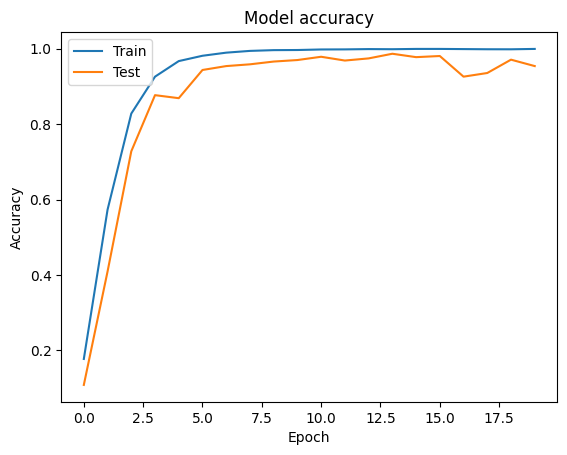

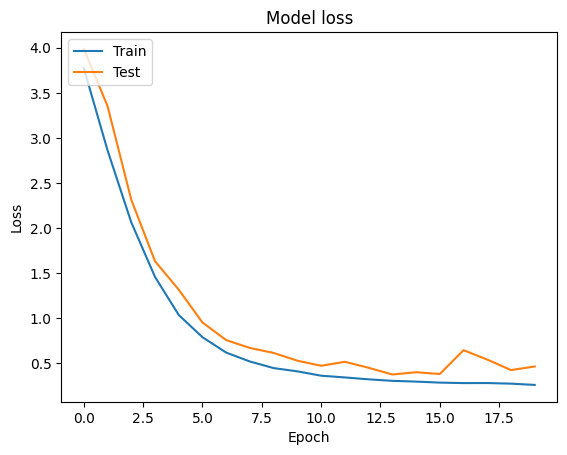

In [21]:
if QKERAS_TRAIN:
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Test')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

In [22]:
y_qkeras = model.predict(np.ascontiguousarray(X_test))

print("QKeras accuracy: {:.6f}%".format(100.*accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))

94/94 [==============================] - 3s 26ms/step
QKeras accuracy: 95.393858%


Pre trained model sul have accuracy = 98.030708%

## QKeras to hls4ml (Quantization Aware Training)

In [23]:
import hls4ml
import plotting

# Then the QKeras model
hls_config_q = hls4ml.utils.config_from_keras_model(model, granularity='name')
hls_config_q['Model']['ReuseFactor'] = 256
hls_config_q['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config_q['LayerName']['output_softmax']['Strategy'] = 'Stable'
plotting.print_dict(hls_config_q)

cfg_q = hls4ml.converters.create_config(backend='VivadoAccelerator')
cfg_q['IOType'] = 'io_stream'  # Must set this if using CNNs!
cfg_q['HLSConfig'] = hls_config_q
cfg_q['KerasModel'] = model
cfg_q['OutputDir'] = 'projects/qat_hls4ml_prj'
cfg_q['XilinxPart'] = 'xczu5ev-sfvc784-2LV-e'

hls_model_q = hls4ml.converters.keras_to_hls(cfg_q)
hls_model_q.compile()

/home/esp2024/rht2122/miniconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


Interpreting Model
Topology:
Layer name: input_3, layer type: InputLayer, input shapes: [[None, 64, 64, 3]], output shape: [None, 64, 64, 3]
Layer name: conv_0, layer type: QConv2D, input shapes: [[None, 64, 64, 3]], output shape: [None, 62, 62, 4]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 62, 62, 4]], output shape: [None, 62, 62, 4]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 62, 62, 4]], output shape: [None, 31, 31, 4]
Layer name: conv_1, layer type: QConv2D, input shapes: [[None, 31, 31, 4]], output shape: [None, 29, 29, 8]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 29, 29, 8]], output shape: [None, 29, 29, 8]
Layer name: pool_1, layer type: MaxPooling2D, input shapes: [[None, 29, 29, 8]], output shape: [None, 14, 14, 8]
Layer name: flatten_2, layer type: Reshape, input shapes: [[None, 14, 14, 8]], output shape: [None, 1568]
Layer name: dense_0, layer type: QDense, input shapes: [[None, 1568]], output sha

In [ ]:
hls_model.compile()

In [24]:
# IF PREDICTION TAKE TOO MUCH PLEASE
# REDUCE THE NUMBER OF INPUTS
print(X_test.shape)
print(X_test[:10].shape)

(2996, 64, 64, 3)
(10, 64, 64, 3)


In [26]:
y_qkeras = model.predict(np.ascontiguousarray(X_test))
y_hls = hls_model_q.predict(np.ascontiguousarray(X_test))

94/94 [==============================] - 1s 15ms/step


In [27]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

#print("Accuracy baseline:  {:.6f}%".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("Accuracy quantized: {:.6f}%".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml:    {:.6f}%".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

Accuracy quantized: 0.953939%
Accuracy hls4ml:    0.922897%


```
With pretrained model you should expect:
Accuracy quantized: 0.980307%
Accuracy hls4ml:    0.979973%
```

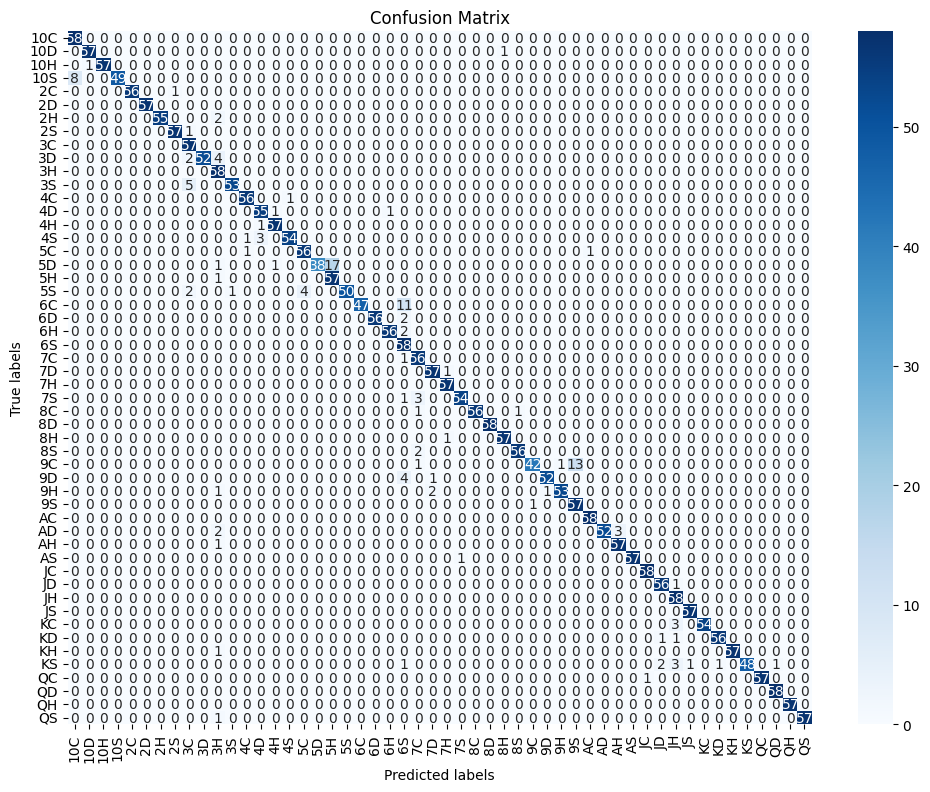

In [28]:
from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, class_names):
    """
    Plots a confusion matrix using seaborn's heatmap.
    
    Args:
        cm (array, shape = [n, n]): Confusion matrix
        class_names (array, shape = [n]): Array of class names
    """
    plt.figure(figsize=(12, 9))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

y_test_ = np.argmax(y_test, axis=1)
y_qkeras_ = np.argmax(y_qkeras, axis=1)

cm = confusion_matrix(y_test_, y_qkeras_)

plot_confusion_matrix(cm, classes)

In [30]:
import os

os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

hls_model_q.build(csim=False, synth=False, vsynth=True, cosim = False, bitfile = True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /opt/xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/opt/xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'rht2122' on host 'socp06-ubuntu.c.psyched-span-141520.internal' (Linux_x86_64 version 5.4.0-1106-gcp) on Fri Apr 05 15:55:24 UTC 2024
INFO: [HLS 200-10] On os Ubuntu 18.04.6 LTS
INFO: [HLS 200-10] In directory '/home/esp2024/rht2122/PokerML/PokerML/projects/qat_hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/esp2024/rht2122/PokerML/PokerML/projects/qat_hls4ml_prj/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject_axi.cpp' to the pro

ERROR: [Board 49-71] The board_part definition was not found for tul.com.tw:pynq-z2:part0:1.0. The project's board_part property was not set, but the project's part property was set to xc7z020clg400-1. Valid board_part values can be retrieved with the 'get_board_parts' Tcl command. Check if board.repoPaths parameter is set and the board_part is installed from the tcl app store.


{}

In [29]:
hls_model_q.build(
    csim=False,
    synth=False,
    cosim=False,
    export=False,
    vsynth=False,
    bitfile = True
)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /opt/xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/opt/xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'rht2122' on host 'socp06-ubuntu.c.psyched-span-141520.internal' (Linux_x86_64 version 5.4.0-1106-gcp) on Fri Apr 05 15:54:07 UTC 2024
INFO: [HLS 200-10] On os Ubuntu 18.04.6 LTS
INFO: [HLS 200-10] In directory '/home/esp2024/rht2122/PokerML/PokerML/projects/qat_hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/home/esp2024/rht2122/PokerML/PokerML/projects/qat_hls4ml_prj/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject_axi.cp

ERROR: [Board 49-71] The board_part definition was not found for tul.com.tw:pynq-z2:part0:1.0. The project's board_part property was not set, but the project's part property was set to xc7z020clg400-1. Valid board_part values can be retrieved with the 'get_board_parts' Tcl command. Check if board.repoPaths parameter is set and the board_part is installed from the tcl app store.


INFO: [Common 17-206] Exiting Vivado at Fri Apr  5 15:54:46 2024...
CSynthesis report not found.
Vivado synthesis report not found.
Cosim report not found.
Timing report not found.


{}

In [ ]:
hls4ml.report.read_vivado_report('projects/qat_hls4ml_prj')